In [5]:
from sklearn.metrics import roc_auc_score

# First part. Research

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Loading data

In [7]:
data = pd.read_csv('./train.csv')

In [8]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Casting numeric variables, searching for NaN's

In [9]:
for num_col in num_cols:
    data[num_col] = pd.to_numeric(data[num_col],errors='coerce')
nan_counter, nan_cols = 0, set()
for row in range(len(data["Churn"])):
    for col in range(len(num_cols) + len(cat_cols)):
        try:
            if np.isnan(data.iloc[row][col]):
                nan_counter += 1
                nan_cols.add(col)
        except:
            pass
print(f"Было найдено {nan_counter} NaN-ов в следующих столбцах: {nan_cols}")

Было найдено 9 NaN-ов в следующих столбцах: {2}


For this data NaN's are located only in "TotalSpent" column and not so often. So I can replace them with the mean value of other elements - this will have only a little impact on answer

In [10]:
nan_replacement, non_nan_size = 0, 0
for row in range(len(data["Churn"])):
    if not np.isnan(data.iloc[row][2]):
        nan_replacement += data.iloc[row][2]
        non_nan_size += 1
nan_replacement /= non_nan_size
for row in range(len(data["Churn"])):
    if np.isnan(data["TotalSpent"][row]):
        data["TotalSpent"][row] = nan_replacement
nan_counter, nan_cols = 0, set()
for row in range(len(data["Churn"])):
    for col in range(len(num_cols) + len(cat_cols)):
        try:
            if np.isnan(data.iloc[row][col]):
                nan_counter += 1
                nan_cols.add(col)
        except:
            pass
print(f"Было найдено {nan_counter} NaN-ов в следующих столбцах: {nan_cols}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Было найдено 0 NaN-ов в следующих столбцах: set()


## Анализ данных
Distribution of numeric and categorical variables

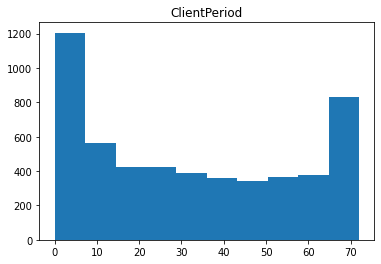

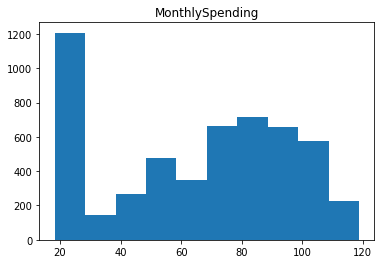

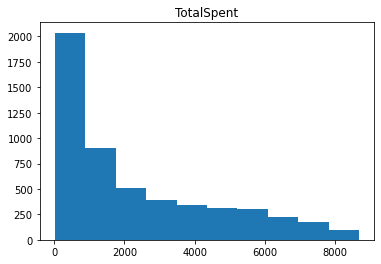

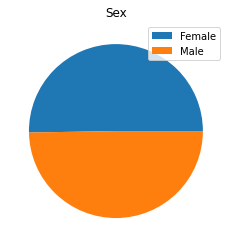

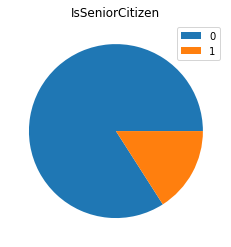

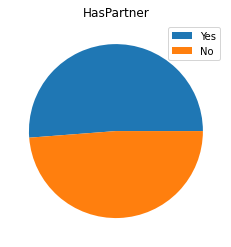

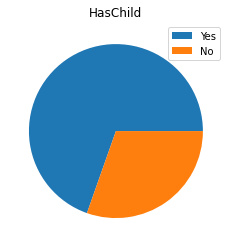

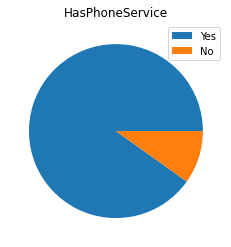

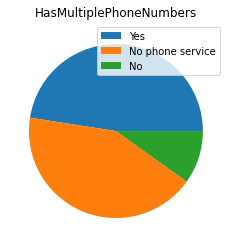

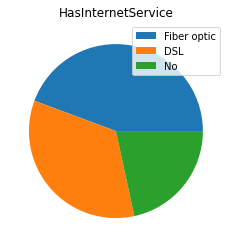

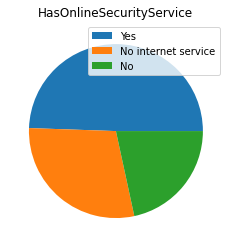

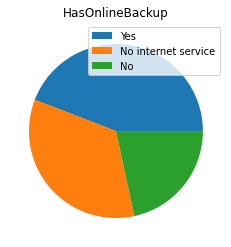

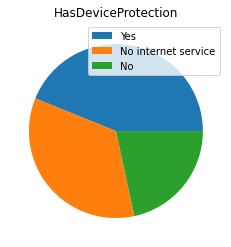

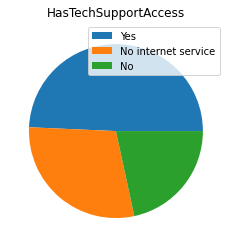

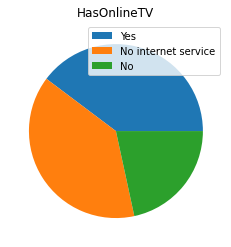

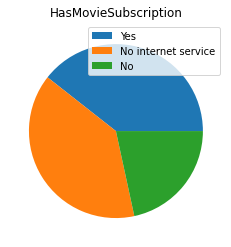

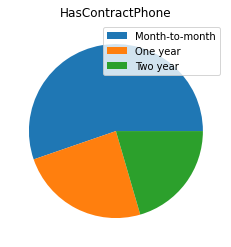

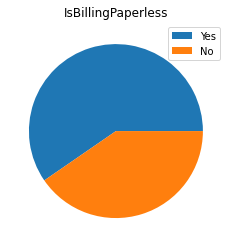

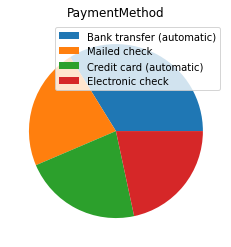

In [11]:
%matplotlib inline
for num_col in num_cols:
    plt.figure()
    plt.title(num_col)
    plt.hist(data[num_col])
for cat_col in cat_cols:
    plt.figure()
    plt.title(cat_col)
    plt.pie(data[cat_col].value_counts())
    plt.legend(list(set(data[cat_col])))

Distribution of target value

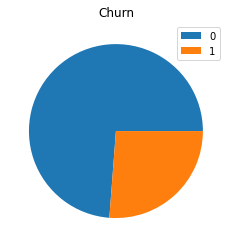

In [12]:
%matplotlib inline
plt.figure()
plt.title("Churn")
plt.pie(data["Churn"].value_counts())
plt.legend(list(set(data["Churn"])))

The difference between two classes is not so big, so we can leave it as it is

Choose **one** of the models below

## Linear model


In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [14]:
data_good = pd.get_dummies(data, columns=cat_cols)
cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data_good.columns))

In [15]:
pca = StandardScaler()
pca.fit(data_good[num_cols + cat_cols_new])
X = pca.transform(data_good[num_cols + cat_cols_new])
y = data_good["Churn"].astype(float)

In [16]:
lr = LogisticRegressionCV(scoring='roc_auc', refit=True)
lr.fit(X, y)

LogisticRegressionCV(scoring='roc_auc')

##Gradient boosting

In [17]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [18]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(learning_rate=0.1, iterations=250, depth=3, verbose=False)
cbc.fit(data[num_cols + cat_cols], data["Churn"].astype(float), cat_features=cat_cols)

# Predictions

In [19]:
best_model = cbc  # cbc / lr
X_test = pd.read_csv('./test.csv')
for num_col in num_cols:
    X_test[num_col] = pd.to_numeric(X_test[num_col],errors='coerce')
for row in range(len(X_test["TotalSpent"])):
    try:
        if np.isnan(X_test.iloc[row][2]):
            X_test["TotalSpent"][row] = nan_replacement
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
if best_model == lr:
    X_test = pca.transform(X_test)
    X_test = pd.get_dummies(X_test, columns=cat_cols)

In [22]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(X_test)
for i in range(len(submission['Churn'])):
    submission["Churn"][i] = 1 - submission["Churn"][i]
submission.to_csv('./my_submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
